Files already downloaded and verified
Files already downloaded and verified
cuda:0
获取一些随机训练数据


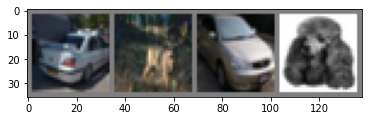

car  deer   car   dog
**********************


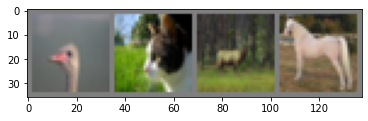

no model file,it will creat a new file!
训练
[1,  2000] loss: 1.992
[1,  4000] loss: 1.642
[1,  6000] loss: 1.498
[1,  8000] loss: 1.416
[1, 10000] loss: 1.379
[1, 12000] loss: 1.327
[2,  2000] loss: 1.250
[2,  4000] loss: 1.217
[2,  6000] loss: 1.184
[2,  8000] loss: 1.147
[2, 10000] loss: 1.138
[2, 12000] loss: 1.129
[3,  2000] loss: 1.046
[3,  4000] loss: 1.045
[3,  6000] loss: 1.040
[3,  8000] loss: 1.020
[3, 10000] loss: 1.010
[3, 12000] loss: 0.997
[4,  2000] loss: 0.912
[4,  4000] loss: 0.930
[4,  6000] loss: 0.941
[4,  8000] loss: 0.921
[4, 10000] loss: 0.945
[4, 12000] loss: 0.924
[5,  2000] loss: 0.849
[5,  4000] loss: 0.858
[5,  6000] loss: 0.874
[5,  8000] loss: 0.879
[5, 10000] loss: 0.870
[5, 12000] loss: 0.856
Finished Training
***************************
***************************
***************************
Time taken: 0:05:11.159865
***************************
***************************
***************************
获取一些随机测试数据


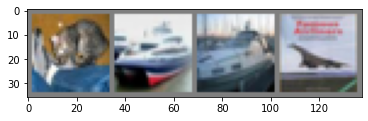

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship truck plane
**********************
输出训练得到的准确度
Accuracy of the network on the 10000 test images: 67 %
Accuracy of plane : 76 %
Accuracy of   car : 83 %
Accuracy of  bird : 57 %
Accuracy of   cat : 44 %
Accuracy of  deer : 62 %
Accuracy of   dog : 64 %
Accuracy of  frog : 62 %
Accuracy of horse : 73 %
Accuracy of  ship : 72 %
Accuracy of truck : 73 %


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim import *


PATH = './cifar_net_tensorboard_net_width_200_and_lr_0o001.pth'  # 保存模型地址

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

print("获取一些随机训练数据")
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("**********************")

# 设置一个tensorborad
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))    

# 设置tensorBoard
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/image_classify_tensorboard')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
# matplotlib_imshow(img_grid, one_channel=True)
imshow(img_grid)

# write to tensorboard
# writer.add_image('imag_classify', img_grid)

# Tracking model training with TensorBoard
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # preds = np.squeeze(preds_tensor.numpy())
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

#

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
# net.to(device)
# # 把net结构可视化出来
writer.add_graph(net, images)
net.to(device)

try:
    net.load_state_dict(torch.load(PATH))
    print("Modle file load successful !")
except:
    print("no model file,it will creat a new file!")

# 训练
print("训练")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

startTime = datetime.now()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # 反向传播求梯度

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            now_loss = running_loss / 2000
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, now_loss))

                        # 把数据写入tensorflow
            # ...log the running loss
            writer.add_scalar('image training loss on net width 200 and lr 0.001',
                            now_loss,
                            epoch * len(trainloader) + i)

            writer.add_scalar('learning rate on net width 200 and lr 0.001',
                            optimizer.state_dict()['param_groups'][0]['lr'],
                            epoch * len(trainloader) + i)                            

            running_loss = 0.0

torch.save(net.state_dict(), PATH)

print('Finished Training')
print("***************************")
print("***************************")
print("***************************")
print("Time taken:", datetime.now() - startTime)
print("***************************")
print("***************************")
print("***************************")



#获取一些随机测试数据
print("获取一些随机测试数据")
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 恢复模型并测试
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

print("**********************")
print("输出训练得到的准确度")
# 输出训练得到的准确度
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Files already downloaded and verified
Files already downloaded and verified
cuda:0
获取一些随机训练数据


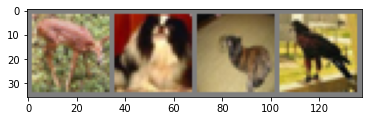

deer   dog   cat  bird
**********************


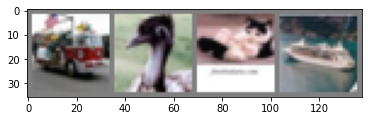

Modle file load successful !
训练
[1,  2000] loss: 1.229
[1,  4000] loss: 1.083
[1,  6000] loss: 1.272
[1,  8000] loss: 1.099
[1, 10000] loss: 1.029
[1, 12000] loss: 1.315
[2,  2000] loss: 1.333
[2,  4000] loss: 1.240
[2,  6000] loss: 1.040
[2,  8000] loss: 1.097
[2, 10000] loss: 1.126
[2, 12000] loss: 1.077
[3,  2000] loss: 1.024
[3,  4000] loss: 1.078
[3,  6000] loss: 0.892
[3,  8000] loss: 0.939
[3, 10000] loss: 0.935
[3, 12000] loss: 1.031
[4,  2000] loss: 0.966
[4,  4000] loss: 0.908
[4,  6000] loss: 0.964
[4,  8000] loss: 0.889
[4, 10000] loss: 1.071
[4, 12000] loss: 1.071
[5,  2000] loss: 0.940
[5,  4000] loss: 1.020
[5,  6000] loss: 0.929
[5,  8000] loss: 1.137
[5, 10000] loss: 0.990
[5, 12000] loss: 0.946
[6,  2000] loss: 0.805
[6,  4000] loss: 0.985
[6,  6000] loss: 0.876
[6,  8000] loss: 0.949
[6, 10000] loss: 0.835
[6, 12000] loss: 0.858
[7,  2000] loss: 1.042
[7,  4000] loss: 1.229
[7,  6000] loss: 1.002
[7,  8000] loss: 0.896
[7, 10000] loss: 1.141
[7, 12000] loss: 1.015
[8

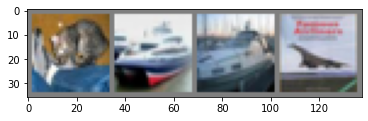

GroundTruth:    cat  ship  ship plane
Predicted:   ship  ship  ship  ship
**********************
输出训练得到的准确度
Accuracy of the network on the 10000 test images: 18 %
Accuracy of plane :  4 %
Accuracy of   car :  0 %
Accuracy of  bird :  8 %
Accuracy of   cat :  0 %
Accuracy of  deer : 27 %
Accuracy of   dog :  0 %
Accuracy of  frog : 30 %
Accuracy of horse : 10 %
Accuracy of  ship : 98 %
Accuracy of truck :  0 %


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim import *


PATH = './cifar_net_tensorboard_net_width_200_and_chang_lr_by_decrease_0_35^x.pth'  # 保存模型地址

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

print("获取一些随机训练数据")
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("**********************")

# 设置一个tensorborad
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))    

# 设置tensorBoard
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/image_classify')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
# matplotlib_imshow(img_grid, one_channel=True)
imshow(img_grid)

# write to tensorboard
# writer.add_image('imag_classify', img_grid)

# Tracking model training with TensorBoard
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # preds = np.squeeze(preds_tensor.numpy())
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

#

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
# # 把net结构可视化出来
writer.add_graph(net, images)
net.to(device)

try:
    net.load_state_dict(torch.load(PATH))
    print("Modle file load successful !")
except:
    print("no model file,it will creat a new file!")

# 训练
print("训练")
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#在发现loss不再降低或者acc不再提高之后，降低学习率。
optimizer = torch.optim.SGD(net.parameters(), lr=0.0009575, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.35,verbose=1,min_lr=0.0001,patience=125)

startTime = datetime.now()
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad() #将参数的grad值初始化为0

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #计算损失
        loss.backward() # 反向传播
        optimizer.step() # 反向传播求梯度

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            now_loss = running_loss / 2000 # 2000mini-batches 的平均损失率
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, now_loss))
            # now_loss = running_loss / 2000
            
            scheduler.step(now_loss)

                        # 把数据写入tensorflow
            # ...log the running loss
            writer.add_scalar('image training loss on net width 200 chang_lr_by_decrease',
                            now_loss,
                            epoch * len(trainloader) + i)

            writer.add_scalar('learning rate on net width 200 chang_lr_by_decrease',
                            optimizer.state_dict()['param_groups'][0]['lr'],
                            epoch * len(trainloader) + i)                            

            running_loss = 0.0

torch.save(net.state_dict(), PATH)

print('Finished Training')
print("***************************")
print("***************************")
print("***************************")
print("Time taken:", datetime.now() - startTime)
print("***************************")
print("***************************")
print("***************************")



#获取一些随机测试数据
print("获取一些随机测试数据")
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 恢复模型并测试
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

print("**********************")
print("输出训练得到的准确度")
# 输出训练得到的准确度
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Modle file reload successful !
再次训练
[1,  2000] loss: 0.700
[1,  4000] loss: 0.752
[1,  6000] loss: 0.613
[1,  8000] loss: 0.659
[1, 10000] loss: 0.570
[1, 12000] loss: 0.563
[2,  2000] loss: 0.489
[2,  4000] loss: 0.511
[2,  6000] loss: 0.523
[2,  8000] loss: 0.650
[2, 10000] loss: 0.608
[2, 12000] loss: 0.586
[3,  2000] loss: 0.592
[3,  4000] loss: 0.643
[3,  6000] loss: 0.601
[3,  8000] loss: 0.679
[3, 10000] loss: 0.680
[3, 12000] loss: 0.676
[4,  2000] loss: 0.819
[4,  4000] loss: 0.608
[4,  6000] loss: 0.645
[4,  8000] loss: 0.779
[4, 10000] loss: 0.676
[4, 12000] loss: 0.825
[5,  2000] loss: 0.658
[5,  4000] loss: 0.677
[5,  6000] loss: 0.664
[5,  8000] loss: 0.598
[5, 10000] loss: 0.632
[5, 12000] loss: 0.684
[6,  2000] loss: 0.469
[6,  4000] loss: 0.533
[6,  6000] loss: 0.558
[6,  8000] loss: 0.712
[6, 10000] loss: 0.660
[6, 12000] loss: 0.740
[7,  2000] loss: 0.691
[7,  4000] loss: 0.664
[7,  6000] loss: 0.688
[7,  8000] loss: 0.682
[7, 10000] loss: 0.674
[7, 12000] loss: 0.69

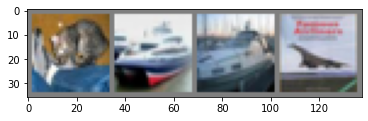

GroundTruth:    cat  ship  ship plane
Predicted:  truck truck truck plane
**********************
输出训练得到的准确度
Accuracy of the network on the 10000 test images: 39 %
Accuracy of plane : 29 %
Accuracy of   car : 24 %
Accuracy of  bird : 24 %
Accuracy of   cat : 51 %
Accuracy of  deer : 32 %
Accuracy of   dog : 19 %
Accuracy of  frog : 46 %
Accuracy of horse : 42 %
Accuracy of  ship : 29 %
Accuracy of truck : 92 %


In [6]:
net = Net()
# 把net结构可视化出来
writer.add_graph(net, images)
net.to(device)

try:
    net.load_state_dict(torch.load(PATH))
    print("Modle file reload successful !")
except:
    print("no model file,it will creat a new file!")

# 训练
print("再次训练")
criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#在发现loss不再降低或者acc不再提高之后，降低学习率。
optimizer = torch.optim.SGD(net.parameters(), lr=0.0009955, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9998,verbose=1,min_lr=0.0001,patience=80)

startTime = datetime.now()
for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad() #将参数的grad值初始化为0

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #计算损失
        loss.backward() # 反向传播
        optimizer.step() # 反向传播求梯度

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            now_loss = running_loss / 2000 # 2000mini-batches 的平均损失率
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, now_loss))
            # now_loss = running_loss / 2000
            
            scheduler.step(now_loss)

                        # 把数据写入tensorflow
            # ...log the running loss
            writer.add_scalar('image training loss on net width 200 chang_lr_by_decrease',
                            now_loss,
                            epoch * len(trainloader) + i)

            writer.add_scalar('learning rate on net width 200 chang_lr_by_decrease',
                            optimizer.state_dict()['param_groups'][0]['lr'],
                            epoch * len(trainloader) + i)                            

            running_loss = 0.0

torch.save(net.state_dict(), PATH)

print('Finished Training')
print("***************************")
print("***************************")
print("***************************")
print("Time taken:", datetime.now() - startTime)
print("***************************")
print("***************************")
print("***************************")



#获取一些随机测试数据
print("获取一些随机测试数据")
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 恢复模型并测试
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

print("**********************")
print("输出训练得到的准确度")
# 输出训练得到的准确度
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

1:   0.00033512499999999997369118376333574360614875331521
2:   0.00011729374999999998808140888595374917713343165815
3:   0.00004105281249999999176273496326317058446875307709
4:   0.00001436848437499999779458359494554997581872157753
5:   0.00000502896953124999855047790042750222028189455159
6:   0.00000176013933593749940796397042419574319183084299
7:   0.00000061604876757812475043574228575349316372467001
8:   0.00000021561706865234364147668611865621413059557199


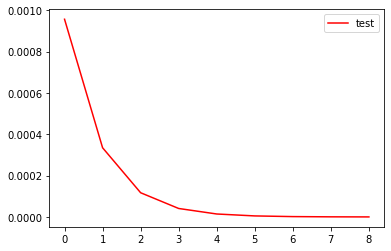

In [1]:
import math 
import matplotlib.pyplot as plt
#%matplotlib inline

x = 0 
o = []
p = []
o.append(0)
p.append(0.0009575)
while(x < 8):
    x += 1
    y = 0.0009575 * math.pow(0.35,x)
    o.append(x)
    p.append(y)
    print('%d:   %.50f' %(x,y))

plt.plot(o,p,c='red',label='test') #分别为x,y轴对应数据,c:color,label
plt.legend(loc='best')  # 显示label,loc为显示位置(best为系统认为最好的位置)
plt.show()